In [22]:
import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import arviz as az

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample


from models import deconvolution


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = 'cpu'


## Inverse problem 

In [23]:
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = 2*N
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

params = [0, 2.0, 0.2, 1.0, 0]

def problem_system(grid: np.array, params)-> np.array:

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= 0.1:
            output[idx] = params[0]
        elif point <= 0.2:
            output[idx] = params[1]
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.75:
            #output[idx] = params[3]
            output[idx] = 0.3*np.sin(2*np.pi*point*2)+params[3]
        else:
            output[idx] = point*params[4]
    
    return output



## Convolution matrix

In [24]:
model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

#A[0,0] = 0
#A[-1, -1] = 0

## Data Generation

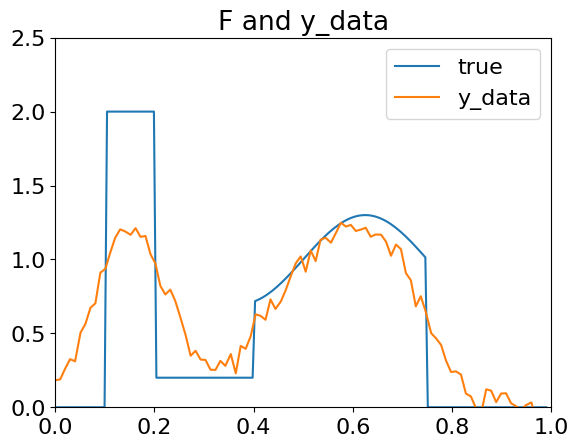

In [25]:
# Generate grid points
x = np.linspace(0, domain[1] - h, n)

# Construct the function f
f = problem_system(x, params)
#f = np.sin(10*x-0.2)
f = A@f
ind = f > 0
f *= ind

# Create y_data with noise
y_data = f + np.random.normal(0, sigma_noise, f.shape)

f = problem_system(x, params)

# Plot f and w
plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='y_data')
plt.axis([domain[0], domain[1], 0, 2.5])
plt.title('F and y_data')
plt.legend()
plt.show()

Old targets

## Pyro BNN

In [27]:
'''
Cauchy-jakaumia BNN:ään. 

'''

class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Normal(0.5,
                                                torch.tensor(0.5, device=device)).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.5, device=device)).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Cauchy(0.5,
                                                torch.tensor(0.5, device=device)).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05, device=device)).expand([h2]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        
        x = x#.reshape(-1, 1)

        x = self.relu(self.fc1(x))#.squeeze()
        mu = self.relu(self.fc2(x))
        #mu = x
        sigma = pyro.sample("sigma", dist.Uniform(0.,
                                                torch.tensor(1.0, device=device)))
    
        with pyro.plate("data", 200):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu


In [28]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(t).float()
y_train = torch.from_numpy(y_data).float()


Warmup:   0%|          | 0/100 [00:00, ?it/s]

RuntimeError: The size of tensor a (100) must match the size of tensor b (200) at non-singleton dimension 0

## Sampling with NUTS

In [13]:
import torch
import pyro
import pyro.distributions as dist
import pyro.infer


A = torch.tensor(A, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

# Define the model in Pyro
def inverse_model(A, y_data):
    n = A.size(1)  # Number of features
    
    # Priors for the weights (omega)
    #omega = pyro.sample("omega", dist.Normal(1, 1).expand([n]).to_event(1))
        
    # Prior for the standard deviation of the noise
    #sigma = pyro.sample("sigma", dist.HalfNormal(1.0))

    bnn_model = BNN(h1=N, h2=n)
    
    # Linear model
    mu = bnn_model()
    
    # Likelihood (sampling distribution) of observations
    with pyro.plate("data", len(y_data)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y_data)


# Define the NUTS sampler
inverse_nuts_kernel = pyro.infer.NUTS(inverse_model)
mcmc = pyro.infer.MCMC(inverse_nuts_kernel, num_samples=200, warmup_steps=100)

# Run MCMC
mcmc.run(A, y_data)

# Extract samples
posterior_samples = mcmc.get_samples()

# Analyze the results
alpha_samples = posterior_samples['omega'].numpy()
sigma_samples = posterior_samples['sigma'].numpy()


Sample: 100%|██████████| 300/300 [00:46,  6.49it/s, step size=6.28e-02, acc. prob=0.908]


In [14]:
pyro_omega = np.mean(alpha_samples, axis=0)
pyro_omega.shape

(200,)

Text(0.5, 1.0, 'Setup of the problem')

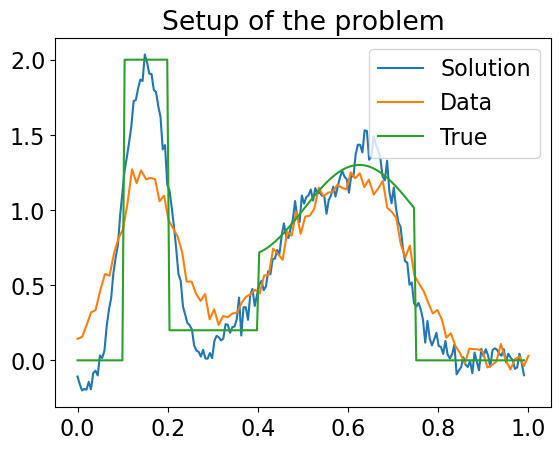

In [15]:
plt.plot(x, pyro_omega)
plt.plot(t, y_data)
plt.plot(x, f)
plt.legend(['Solution', 'Data', 'True'])
plt.title('Setup of the problem')
#plt.savefig('../plot_from_dev/working_gaussian.png')

# Fitting BNN to different signals and learning parameters